# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [4]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = 1e-4*(np.rot90(Bx))
B[1, :, :] = 1e-4*(np.rot90(By))
B[2, :, :] = 1e-4*(np.rot90(Bz))
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
dataset.add_hanning_filter(1)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
# dataset.plot_target()

In [5]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 1


In [6]:
print(len(dataset.target.size()))

3


## Reconstruct the current density using a neural network using Bz data

[30, 226, 30, 226]


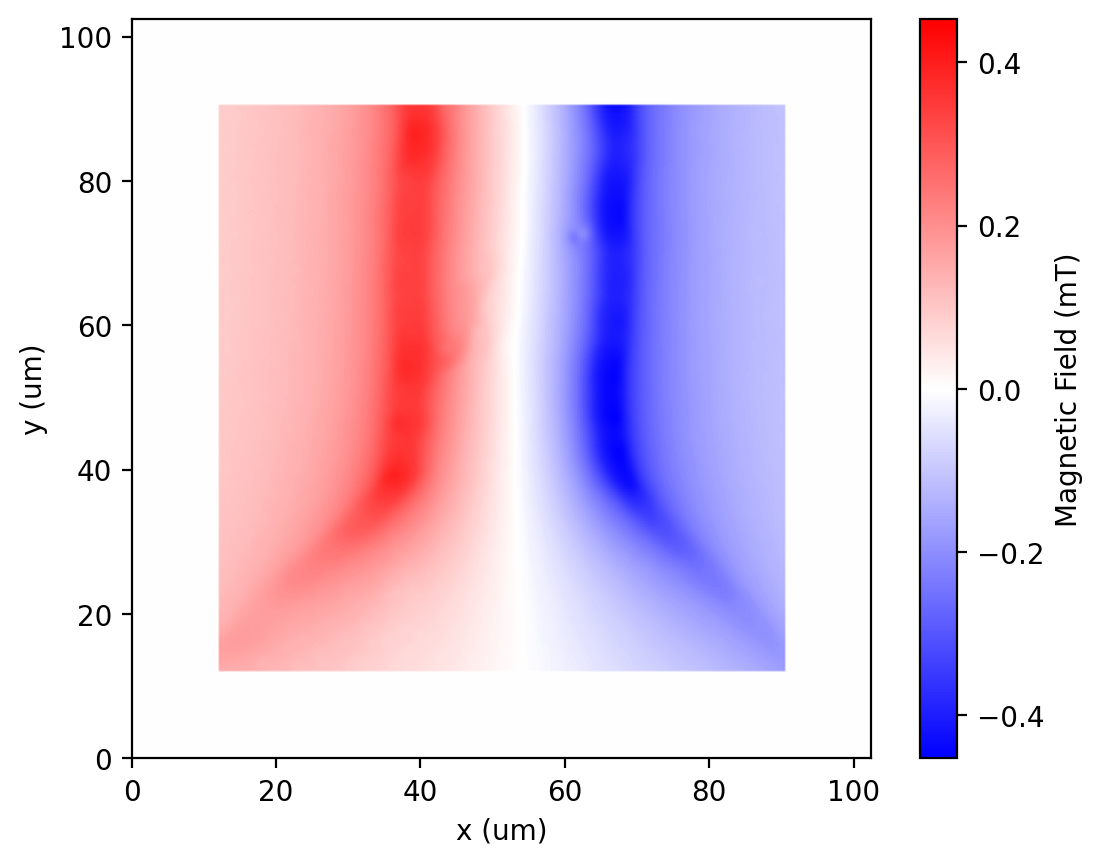

In [7]:
from magrec.method.FCNN import FCNN
from magrec.models.Jxy import Jxy

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset2 = Data()
dataset2.load_data(
       B[2,::] , 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset2.remove_DC_background()
dataset2.add_hanning_filter(1)
dataset2.crop_data((2,198,2,198))
# dataset.pad_reflective2d()
dataset2.pad_data_to_power_of_two()
dataset2.plot_target()

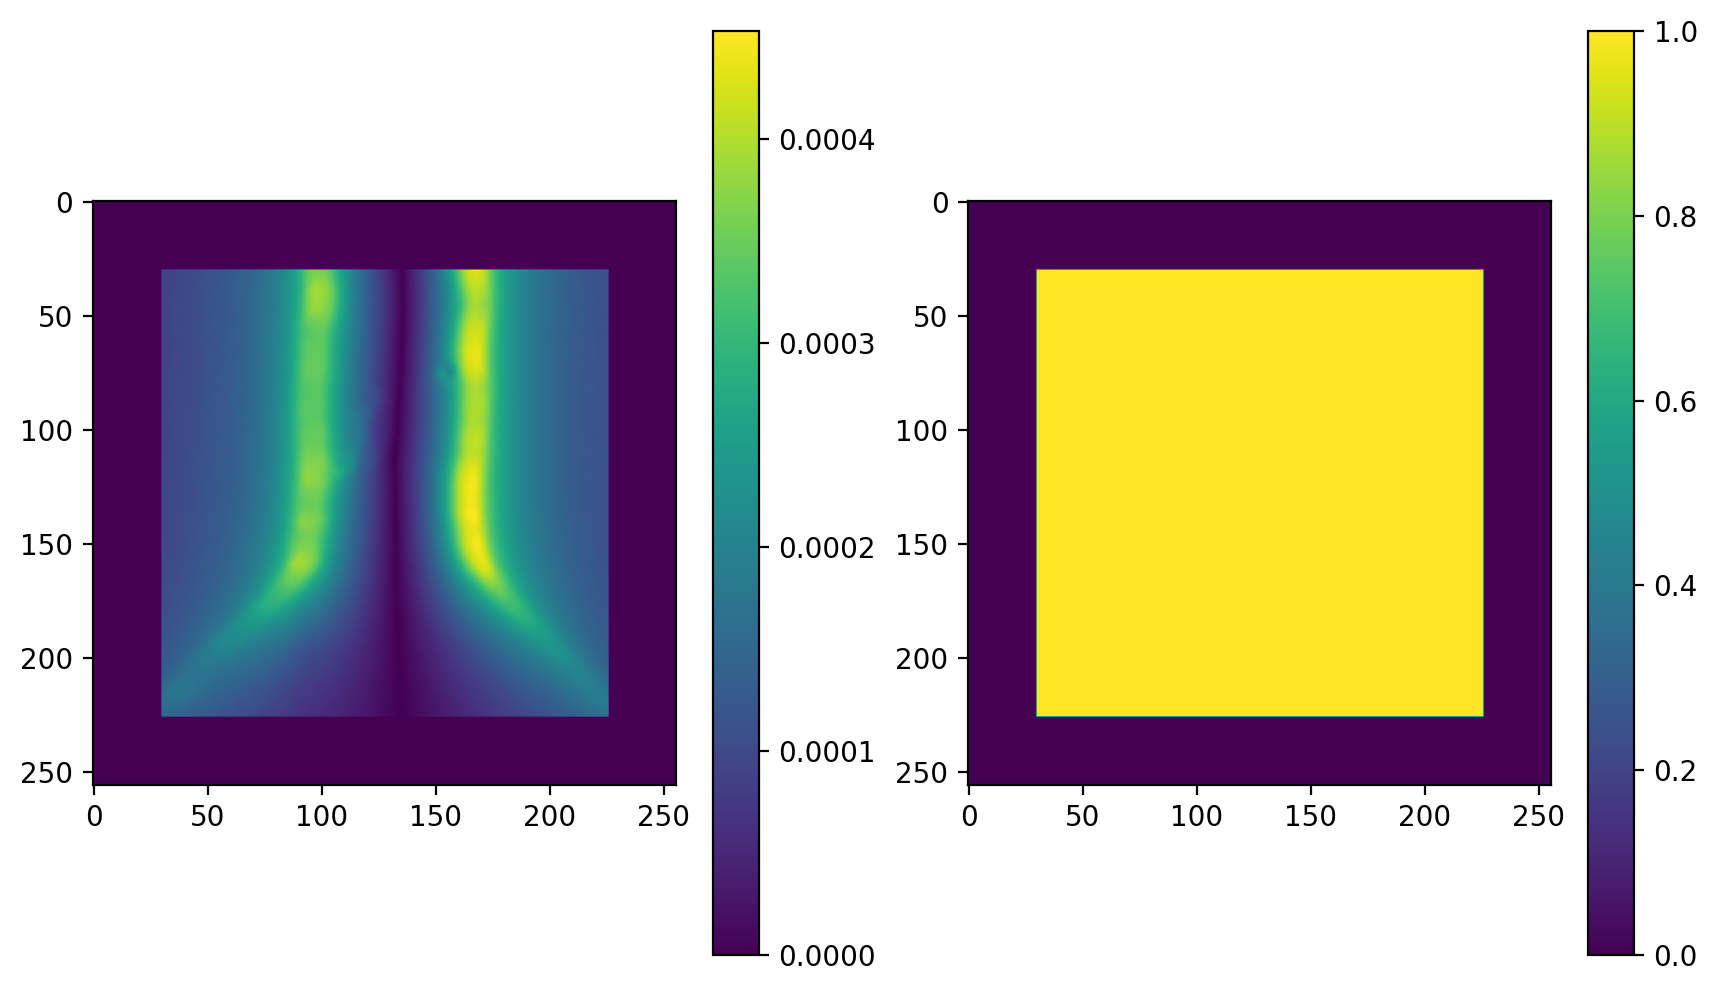

In [8]:
import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_hor_dir(dataset2.target, 0.00005,  plot=True)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1

In [71]:
Model = Jxy(dataset2, "MSE")
FittingMethod = FCNN(Model, dataset2)
# FittingMethod.prepare_fit(loss_weight=weight)
FittingMethod.prepare_fit()

torch.Size([512, 512])
torch.Size([3, 2, 512, 257])
Number of sources: 2
Number of targets: 1


In [72]:
FittingMethod.fit(n_epochs=100)

C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  2.22e+04
epoch    11 | loss on last mini-batch:  1.09e+04
epoch    21 | loss on last mini-batch:  4.00e+03
epoch    31 | loss on last mini-batch:  1.57e+03
epoch    41 | loss on last mini-batch:  7.06e+02
epoch    51 | loss on last mini-batch:  3.35e+02
epoch    61 | loss on last mini-batch:  1.79e+02
epoch    71 | loss on last mini-batch:  1.14e+02
epoch    81 | loss on last mini-batch:  8.30e+01
epoch    91 | loss on last mini-batch:  6.42e+01


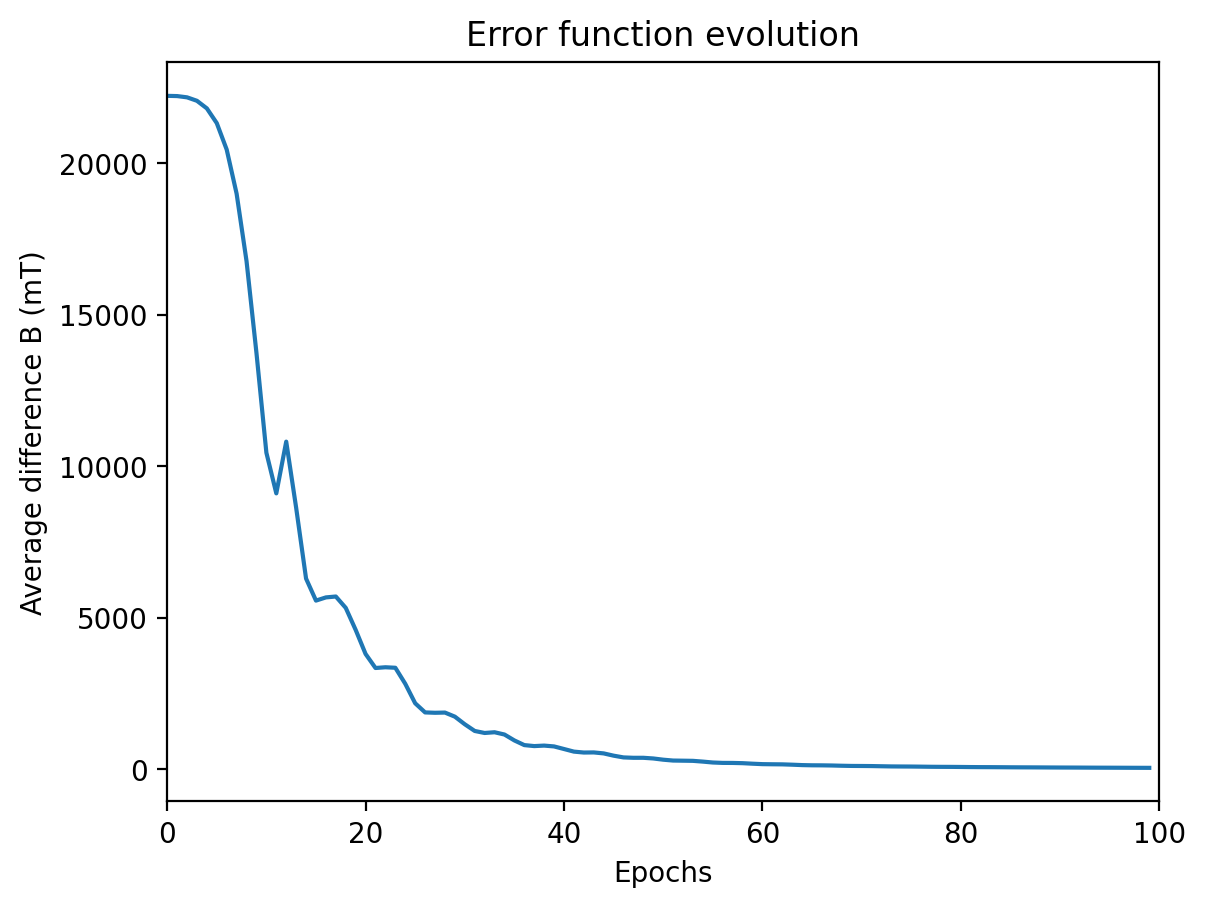

In [11]:
FittingMethod.plot_loss()

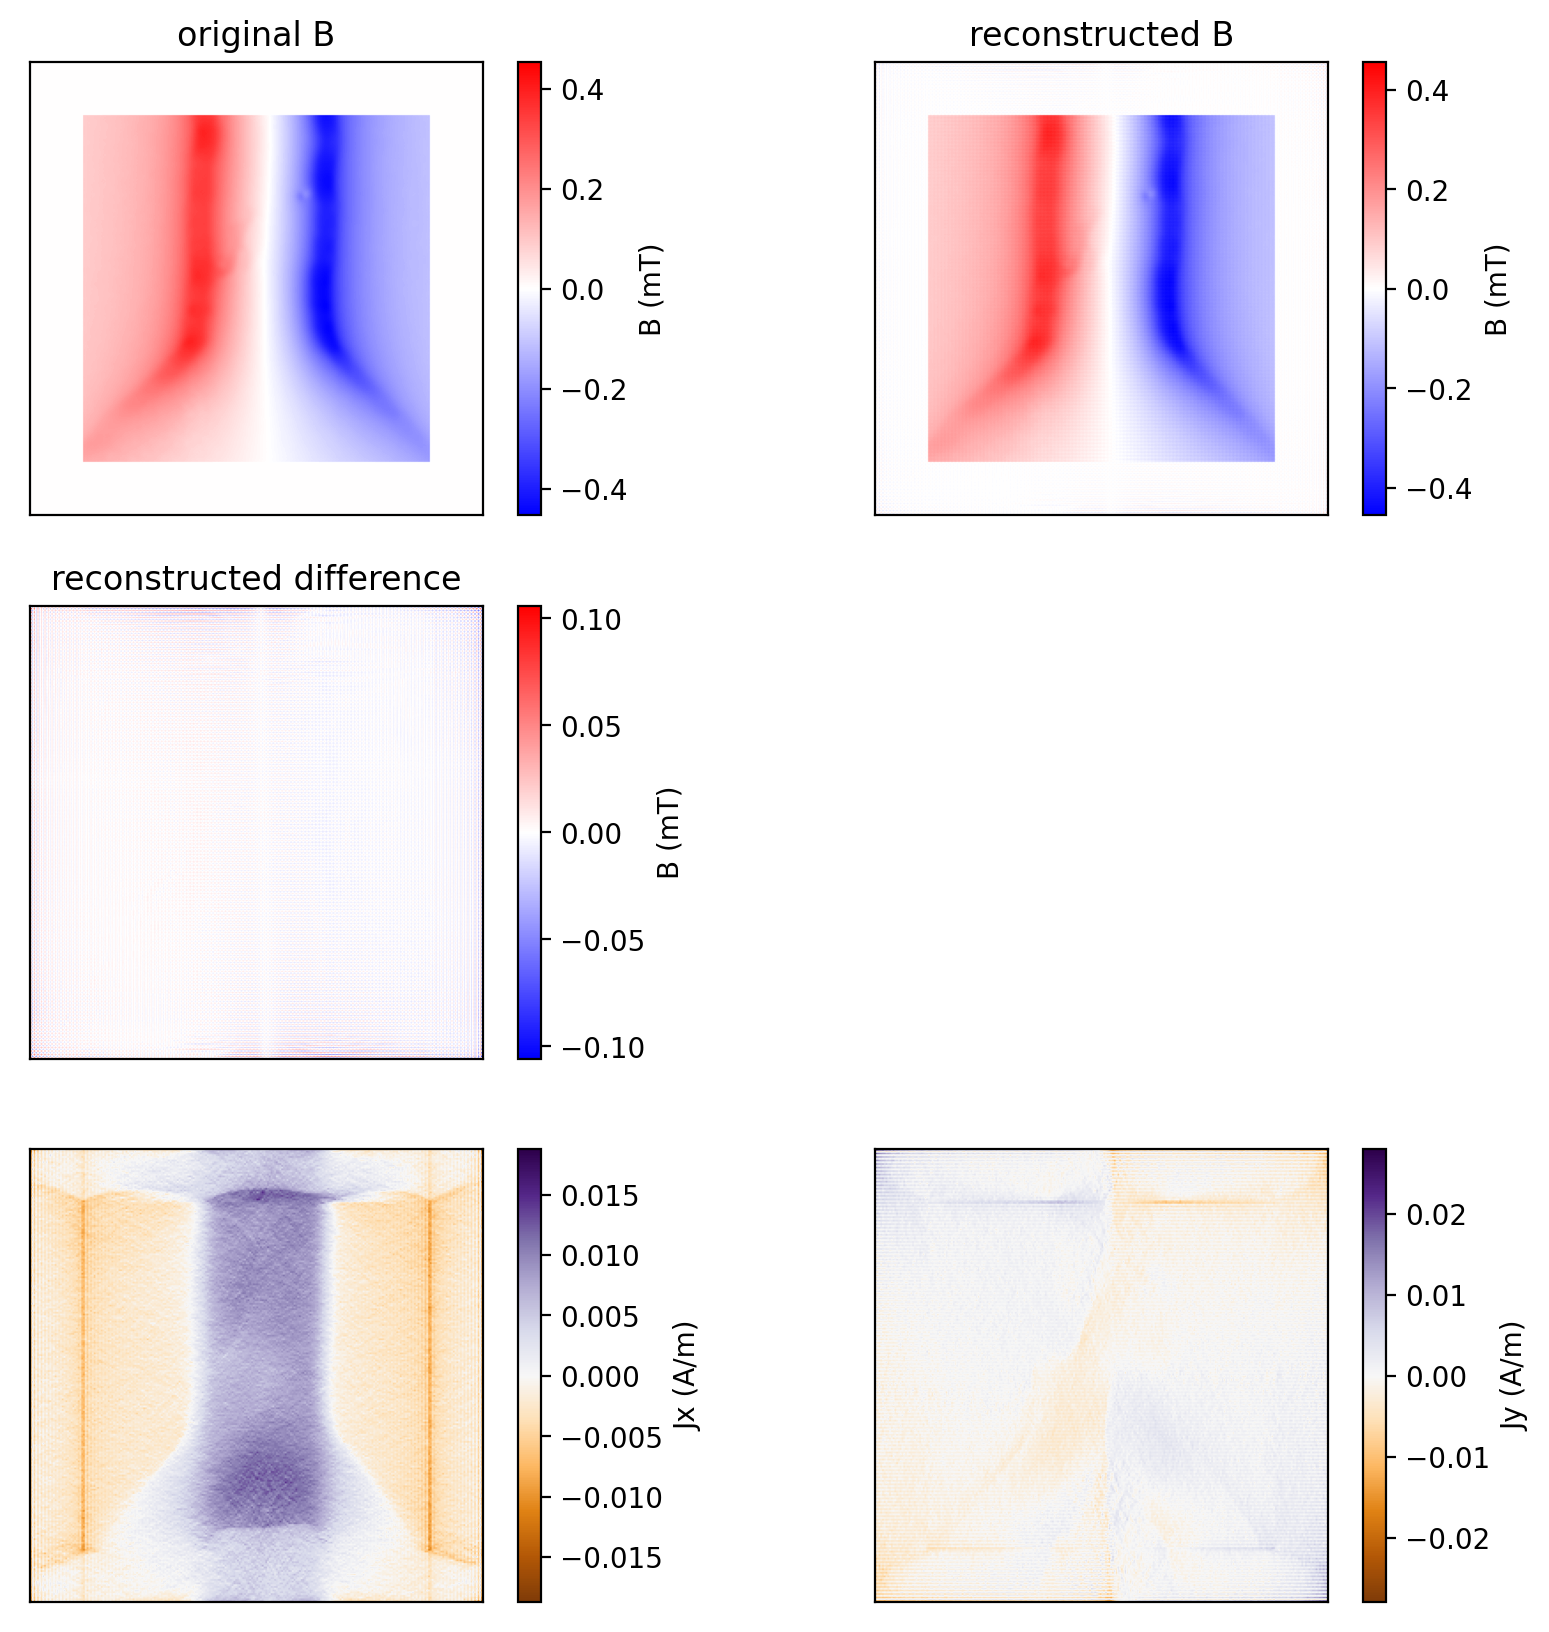

In [12]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()

# Now try recon in Fourier space

In [99]:
from magrec.method.FCNN import FCNN
from magrec.models.JxyFspace import JxyFspace as Jrecon


dataset5 = copy.deepcopy(dataset2)
dataset5.target = dataset5.target

Model = Jrecon(dataset5, "MSE")
FittingMethod = FCNN(Model, dataset5)
FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 1


In [100]:
FittingMethod.fit(n_epochs=150)

C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 256, 258])) that is different to the input size (torch.Size([1, 256, 258])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  1.85e+13
epoch    11 | loss on last mini-batch:  1.85e+13
epoch    21 | loss on last mini-batch:  1.80e+13
epoch    31 | loss on last mini-batch:  1.66e+13
epoch    41 | loss on last mini-batch:  1.48e+13
epoch    51 | loss on last mini-batch:  1.35e+13
epoch    61 | loss on last mini-batch:  1.30e+13
epoch    71 | loss on last mini-batch:  1.29e+13
epoch    81 | loss on last mini-batch:  1.29e+13
epoch    91 | loss on last mini-batch:  1.29e+13
epoch   101 | loss on last mini-batch:  1.29e+13
epoch   111 | loss on last mini-batch:  1.29e+13
epoch   121 | loss on last mini-batch:  1.29e+13
epoch   131 | loss on last mini-batch:  1.29e+13
epoch   141 | loss on last mini-batch:  1.29e+13


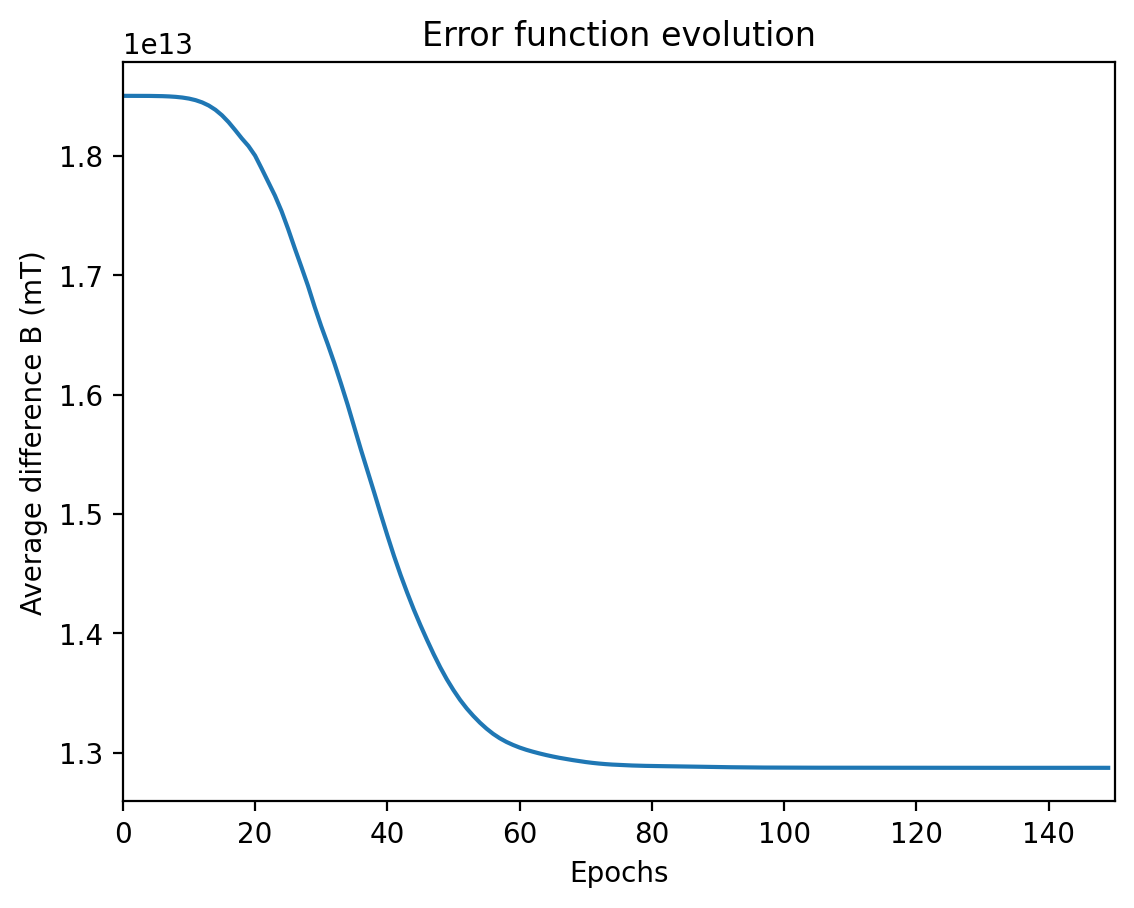

In [101]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


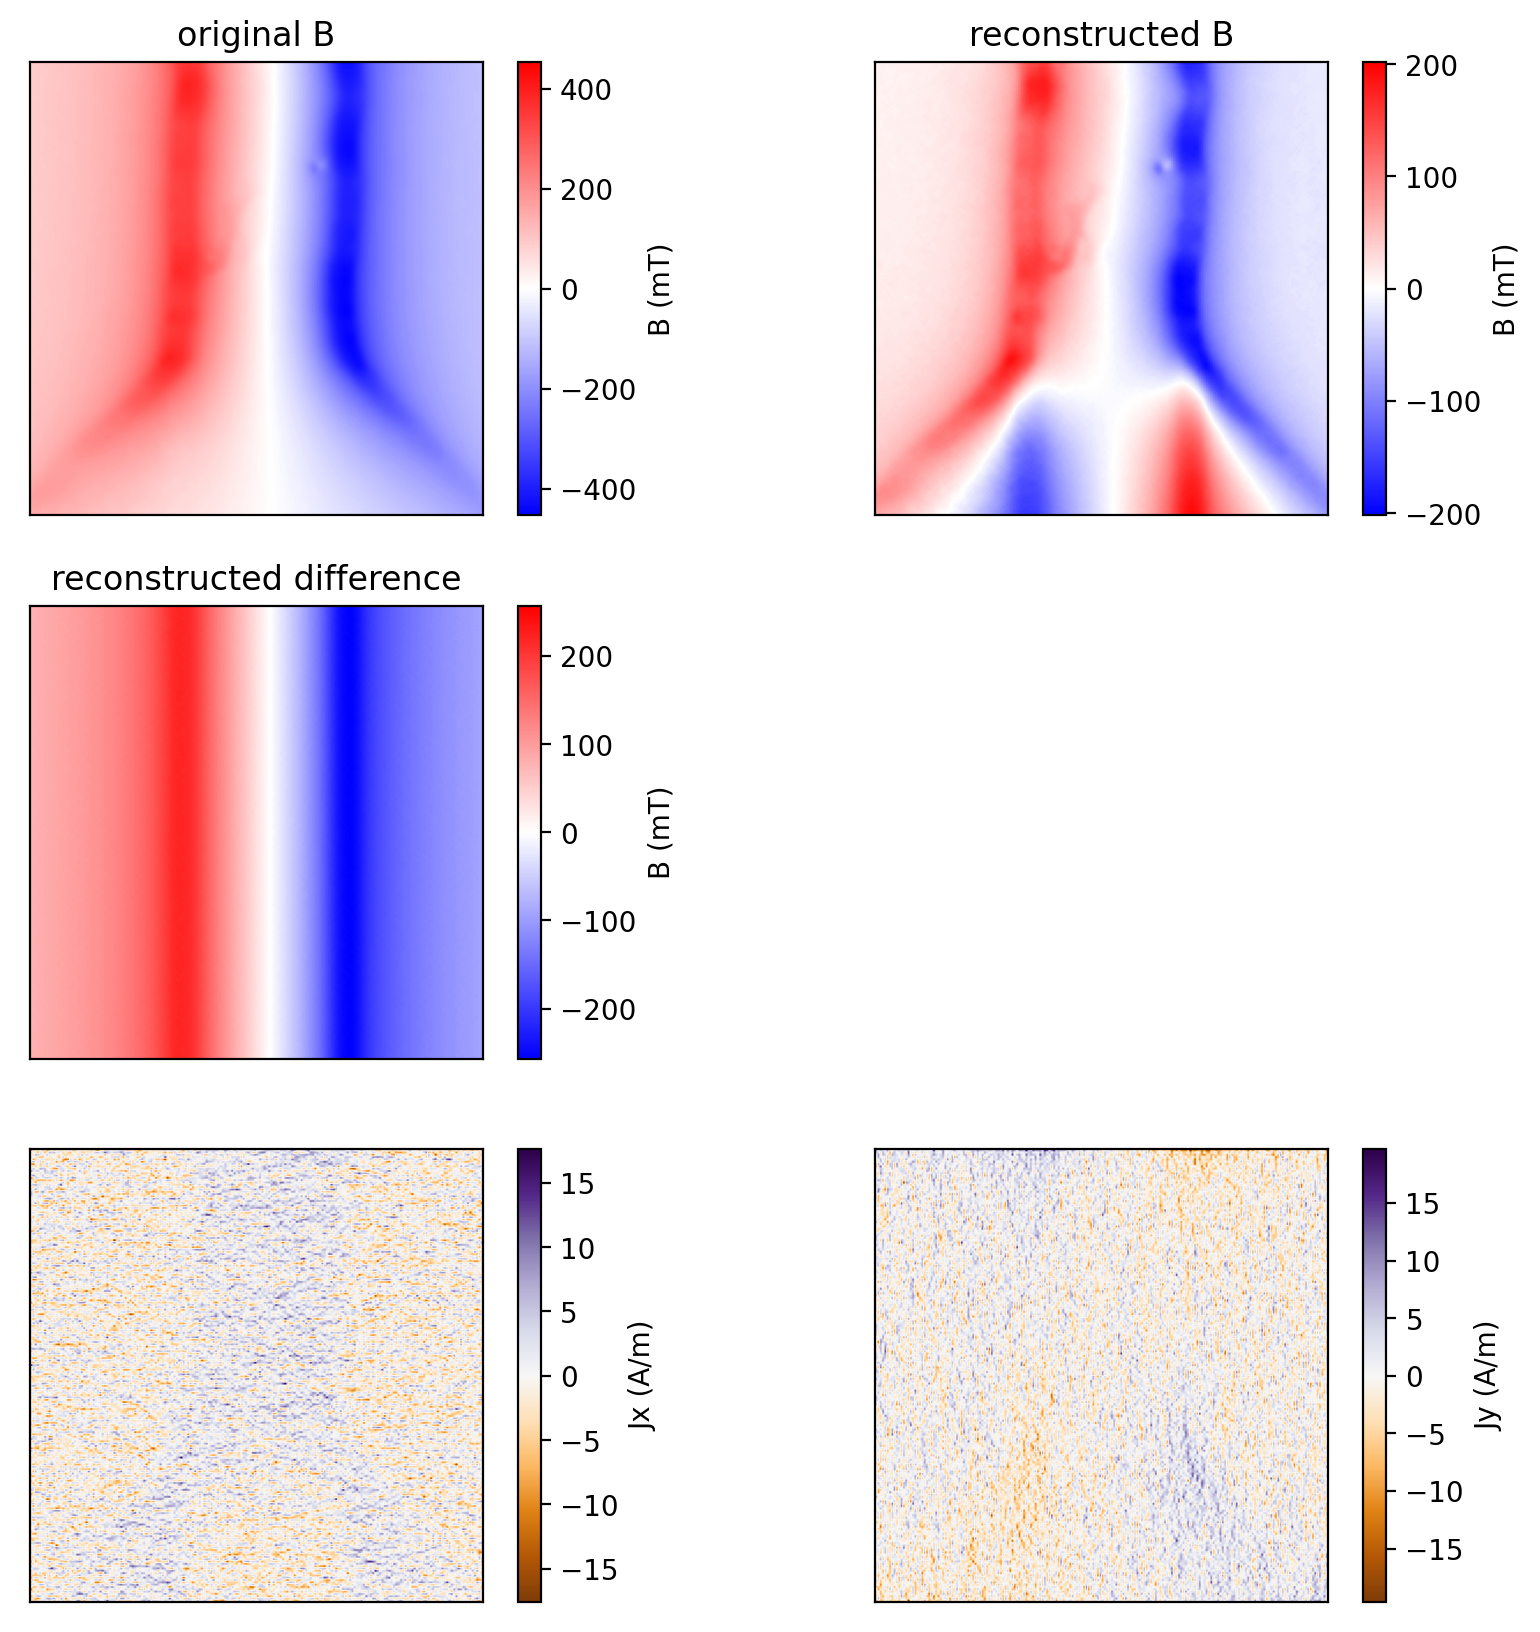

In [102]:
FittingMethod.extract_results()

FittingMethod.plot_results()

Text(0.5, 1.0, 'Difference')

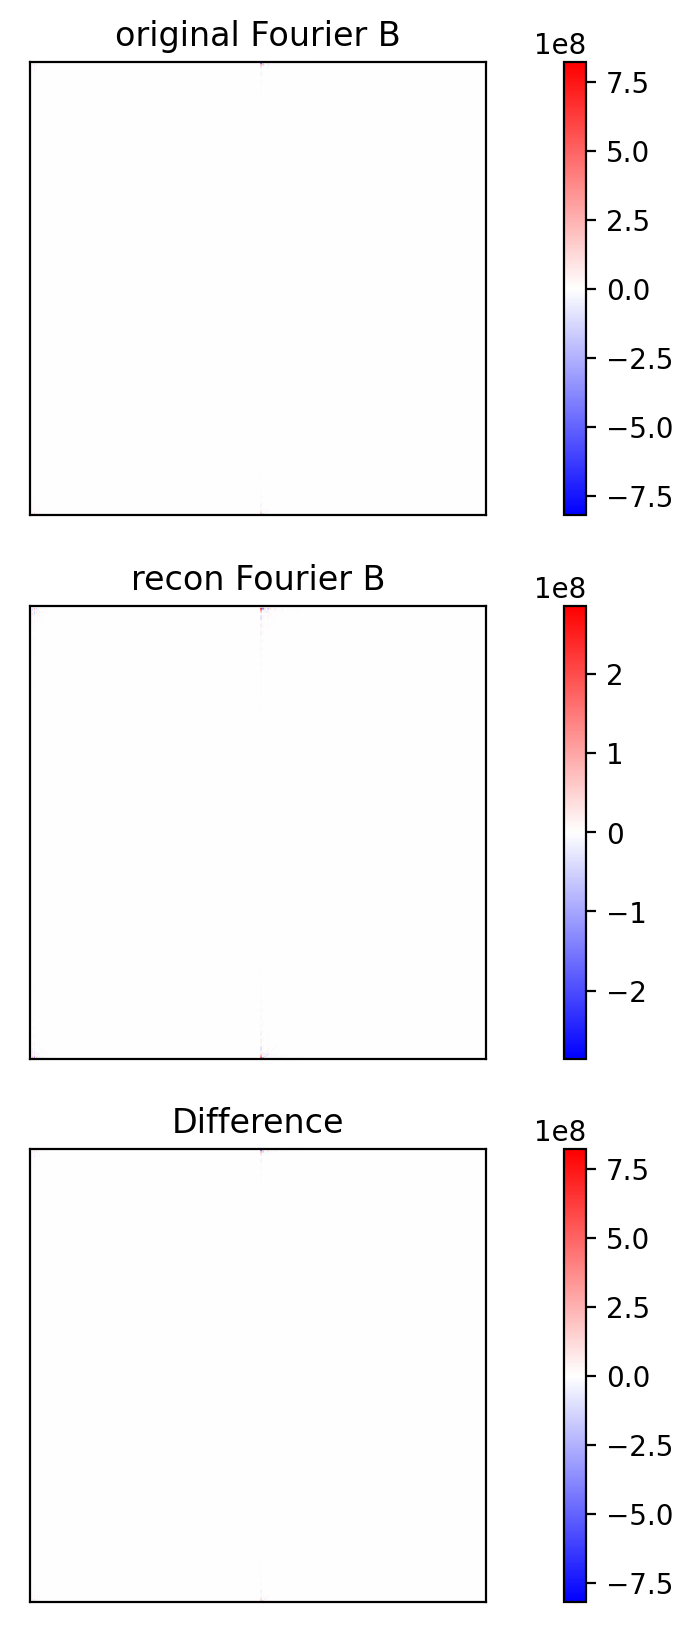

In [107]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(3, 1, 1)
plot_data = FittingMethod.img_comp[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('original Fourier B')

plt.subplot(3, 1, 2)
plot_data = FittingMethod.final_b[0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('recon Fourier B')

plt.subplot(3, 1, 3)
plot_data = FittingMethod.img_comp[0,0,::] - FittingMethod.final_b[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('Difference')
